In [1]:
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import os
import random
import math
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator , load_img , img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense,Dropout
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from mlxtend.plotting import plot_confusion_matrix
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.utils import plot_model

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)  # Memory growth must be set before GPUs have been initialized


In [2]:
df = pd.read_csv("all_datasets_full_df_diabetic_aug.csv")
df.head(3)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,...,target,filename,normal,diabetic,glaucoma,cataract,macular degeneration,hypertensive,myopia,other
0,0,69.0,Female,0_left.jpg,0_right.jpg,['cataract'],['normal fundus'],0,0,0,...,"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg,1,0,0,0,0,0,0,0
1,1,57.0,Male,1_left.jpg,1_right.jpg,['normal fundus'],['normal fundus'],1,0,0,...,"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg,1,0,0,0,0,0,0,0
2,2,42.0,Male,2_left.jpg,2_right.jpg,"['laser spot', 'moderate non diabetic retinopa...",['moderate non diabetic retinopathy'],0,1,0,...,"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg,0,1,0,0,0,0,0,0


In [3]:
df


,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,...,target,filename,normal,diabetic,glaucoma,cataract,macular degeneration,hypertensive,myopia,other
0,0,69.0,Female,0_left.jpg,0_right.jpg,['cataract'],['normal fundus'],0,0,0,...,"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg,1,0,0,0,0,0,0,0
1,1,57.0,Male,1_left.jpg,1_right.jpg,['normal fundus'],['normal fundus'],1,0,0,...,"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg,1,0,0,0,0,0,0,0
2,2,42.0,Male,2_left.jpg,2_right.jpg,"['laser spot', 'moderate non diabetic retinopa...",['moderate non diabetic retinopathy'],0,1,0,...,"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg,0,1,0,0,0,0,0,0
3,4,53.0,Male,4_left.jpg,4_right.jpg,['macular epiretinal membrane'],['mild non diabetic retinopathy'],0,1,0,...,"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg,0,1,0,0,0,0,0,0
4,5,50.0,Female,5_left.jpg,5_right.jpg,['moderate non diabetic retinopathy'],['moderate non diabetic retinopathy'],0,1,0,...,"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82317,80426,55.0,Female,3402_left.jpg,3402_right.jpg,"['lens dust', 'lens dust']","['lens dust', 'normal fundus']",1,0,0,...,NaN,3402_left_other2_22454.jpg,0,0,0,0,0,0,0,1
82318,80427,55.0,Female,3402_left.jpg,3402_right.jpg,"['lens dust', 'lens dust']","['lens dust', 'normal fundus']",1,0,0,...,NaN,3402_left_other3_22455.jpg,0,0,0,0,0,0,0,1
82319,80428,55.0,Male,4149_left.jpg,4149_right.jpg,['low image quality'],['low image quality'],1,0,0,...,NaN,4149_left_other1_22456.jpg,0,0,0,0,0,0,0,1
82320,80429,55.0,Male,4149_left.jpg,4149_right.jpg,['low image quality'],['low image quality'],1,0,0,...,NaN,4149_left_other2_22457.jpg,0,0,0,0,0,0,0,1


In [4]:
df.diabetic.value_counts()

diabetic
0    58913
1    23409
Name: count, dtype: int64

In [5]:
diabetic = df.loc[(df.diabetic ==1)]["filename"].values
diabetic[:15]

array(['2_right.jpg', '4_right.jpg', '5_right.jpg', '6_right.jpg',
       '7_right.jpg', '11_right.jpg', '19_right.jpg', '26_right.jpg',
       '27_right.jpg', '44_right.jpg', '50_right.jpg', '54_right.jpg',
       '64_right.jpg', '67_right.jpg', '71_right.jpg'], dtype=object)

In [6]:
print("Number of images in diabetic: {}".format(len(diabetic)))

Number of images in diabetic: 23409


In [7]:
df.shape

(82322, 27)

In [8]:
df.normal.value_counts()

normal
0    71210
1    11112
Name: count, dtype: int64

In [9]:
normal = df.loc[(df.normal ==1)]["filename"].values
normal[:15]

array(['0_right.jpg', '1_right.jpg', '8_right.jpg', '10_right.jpg',
       '26_right.jpg', '29_right.jpg', '31_right.jpg', '35_right.jpg',
       '37_right.jpg', '38_right.jpg', '47_right.jpg', '49_right.jpg',
       '61_right.jpg', '65_right.jpg', '66_right.jpg'], dtype=object)

In [10]:
print("Number of images in normal: {}".format(len(normal)))

Number of images in normal: 11112


In [11]:
print(len(diabetic),len(normal))

23409 11112


In [12]:
# Balance the dataset
min_size = min(len(diabetic), len(normal))
diabetic = np.random.choice(diabetic, min_size, replace=False)
normal = np.random.choice(normal, min_size, replace=False)

In [13]:
print(len(diabetic),len(normal))

11112 11112


In [14]:
dataset_dir = "all Training Images/"
image_size=224
#labels = []
np.random.seed(56)
def create_dataset(image_category, label):
    dataset = []
    for img in tqdm(image_category):
        image_path = os.path.join(dataset_dir,img)
        try:
            image = cv2.imread(image_path,cv2.IMREAD_COLOR)
            image = cv2.resize(image,(image_size,image_size))
        except:
            continue
        
        dataset.append([np.array(image),np.array(label)])
    random.shuffle(dataset)
    return dataset

In [15]:
dataset = []
dataset += create_dataset(diabetic,1)
dataset += create_dataset(normal,0)

100%|██████████| 11112/11112 [04:51<00:00, 38.18it/s]


In [16]:
len(dataset)

22224

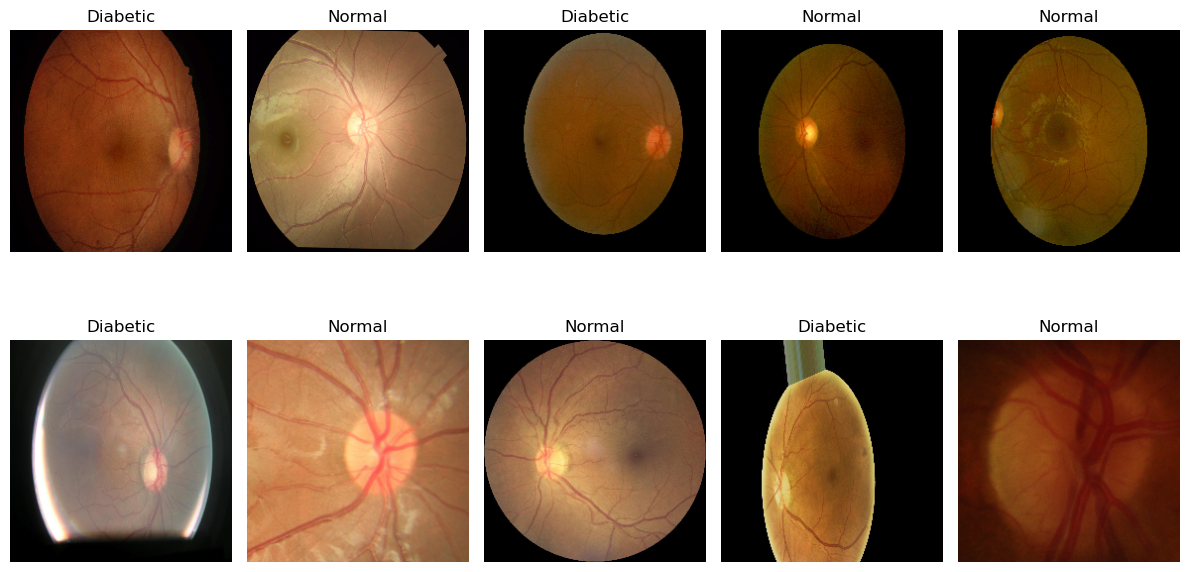

In [17]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(dataset)))
    image = dataset[sample][0]
    category = dataset[sample][1]
    if category== 0:
        label = "Normal"
    else:
        label = "Diabetic"
    plt.subplot(2,5,i+1)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis('off')
    plt.title(label)
plt.tight_layout()    

In [18]:
x = np.array([i[0] for i in dataset]).reshape(-1,image_size,image_size,3)
y = np.array([i[1] for i in dataset])

In [19]:
print(x.shape)
print(y.shape)

(22224, 224, 224, 3)
(22224,)


In [20]:
# Get the Barchat
gt_t = []
for g in y:
    if g == 0:
        gt_t.append("Normal")
    else:
        gt_t.append("Diabetic")
        
gt_t = np.array(gt_t)
gt_t.shape

(22224,)

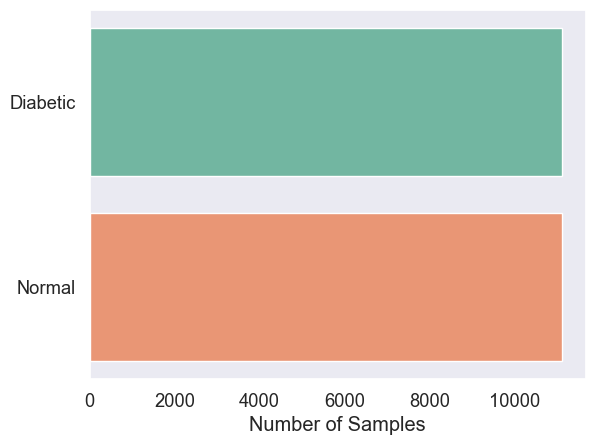

In [21]:
sns.set(style="dark", font_scale=1.2)
ax = sns.countplot(y=gt_t, palette="Set2")

ax.set(xlabel='Number of Samples')
plt.grid(False)
plt.show()

In [22]:
x_train,x_temp,y_train,y_temp = train_test_split(x,y,test_size=0.3)
x_val,x_test,y_val,y_test = train_test_split(x_temp,y_temp,test_size=0.3)

In [56]:
print(f'x_train',x_train.shape)
print(f'x_val',x_val.shape)
print(f'x_test',x_test.shape)
print(f'y_train',y_train.shape)
print(f'y_val',y_val.shape)
print(f'y_test',y_test.shape)

x_train (15556, 224, 224, 3)
x_val (4667, 224, 224, 3)
x_test (2001, 224, 224, 3)
y_train (15556,)
y_val (4667,)
y_test (2001,)


In [24]:
dataset = []
x = []
y= []

In [25]:
train_datagen = ImageDataGenerator(
    #rescale=1./255,
    #rotation_range=40,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #shear_range=0.2,
    #zoom_range=0.2,
    #horizontal_flip=True,
    #fill_mode='nearest'
)

val_datagen = ImageDataGenerator(
    #rescale=1./255
)
test_datagen = ImageDataGenerator(
    #rescale=1./255
)

In [26]:
batch_size=32
train_generator = train_datagen.flow(x_train, y_train, batch_size=batch_size)
validation_generator = val_datagen.flow(x_val, y_val, batch_size=batch_size)
#test_generator = test_datagen.flow(x_test, y_test, batch_size=batch_size)

In [27]:
train_steps = math.ceil(len(x_train) / batch_size)
val_steps = math.ceil(len(x_val) / batch_size)
#test_steps = math.ceil(len(x_test) / batch_size)

In [28]:
vgg = VGG19(weights="imagenet",include_top = False,input_shape=(image_size,image_size,3))

for layer in vgg.layers:
    layer.trainable = False

model = Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(1024,activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1,activation="sigmoid"))

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1024)              25691136  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 45,716,545
Trainable params: 25,692,161
Non-trainable params: 20,024,384
_________________________________________________________________


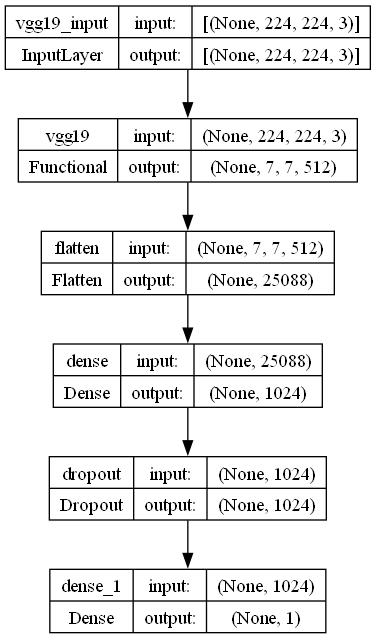

In [30]:
plot_model(model, to_file='model_structure1.png', show_shapes=True, show_layer_names=True)

In [31]:
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy", Precision(), Recall()])

checkpoint = ModelCheckpoint("vgg19_all_datasets_full_df_diabetic_aug.h5",monitor="val_accuracy",verbose=1,save_best_only=True,
                             save_weights_only=False,save_freq='epoch')
earlystop = EarlyStopping(monitor="val_accuracy",patience=40,verbose=1)

**<h1>Trainning<h1>**

In [32]:
history = model.fit(
    train_generator,
    steps_per_epoch= train_steps,
    epochs= 40,
    validation_data= validation_generator,
    validation_steps= val_steps,
    callbacks= [checkpoint, earlystop]
)

Epoch 1/40
487/487 [==============================] - ETA: 0s - loss: 3.1558 - accuracy: 0.7530 - precision: 0.7624 - recall: 0.7354
Epoch 1: val_accuracy improved from -inf to 0.81787, saving model to vgg19_all_datasets_full_df_diabetic_aug.h5
487/487 [==============================] - 102s 167ms/step - loss: 3.1558 - accuracy: 0.7530 - precision: 0.7624 - recall: 0.7354 - val_loss: 0.3860 - val_accuracy: 0.8179 - val_precision: 0.8585 - val_recall: 0.7661
Epoch 2/40
487/487 [==============================] - ETA: 0s - loss: 0.4041 - accuracy: 0.8041 - precision: 0.8351 - recall: 0.7580
Epoch 2: val_accuracy improved from 0.81787 to 0.85237, saving model to vgg19_all_datasets_full_df_diabetic_aug.h5
487/487 [==============================] - 77s 158ms/step - loss: 0.4041 - accuracy: 0.8041 - precision: 0.8351 - recall: 0.7580 - val_loss: 0.3350 - val_accuracy: 0.8524 - val_precision: 0.8732 - val_recall: 0.8284
Epoch 3/40
487/487 [==============================] - ETA: 0s - loss: 0.37

In [33]:
loss, accuracy, precision, recall = model.evaluate(x_val,y_val)
print("loss:",loss)
print("Accuracy:",accuracy)

146/146 [==============================] - 17s 114ms/step - loss: 0.3607 - accuracy: 0.8969 - precision: 0.9159 - recall: 0.8767
loss: 0.3606579005718231
Accuracy: 0.8969359397888184


In [34]:
loss, accuracy, precision, recall = model.evaluate(x_test,y_test)
print("loss:",loss)
print("Accuracy:",accuracy)

63/63 [==============================] - 10s 151ms/step - loss: 0.3835 - accuracy: 0.8906 - precision: 0.9068 - recall: 0.8629
loss: 0.3834836781024933
Accuracy: 0.8905547261238098


In [35]:
# Use the predict method to get the predicted probabilities
y_pred_probabilities = model.predict(x_test,batch_size=16)

# Convert probabilities to class labels
#y_pred = np.argmax(y_pred_probabilities, axis=1)
y_pred = (y_pred_probabilities > 0.5).astype(int)


126/126 [==============================] - 10s 62ms/step


In [36]:
y_pred_probabilities

array([[0.3654344 ],
       [1.        ],
       [1.        ],
       ...,
       [0.45375192],
       [0.00178747],
       [1.        ]], dtype=float32)

In [37]:
accuracy_score(y_test,y_pred)

0.8905547226386806

In [38]:
print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

           0       0.88      0.92      0.90      1031
           1       0.91      0.86      0.88       970

    accuracy                           0.89      2001
   macro avg       0.89      0.89      0.89      2001
weighted avg       0.89      0.89      0.89      2001



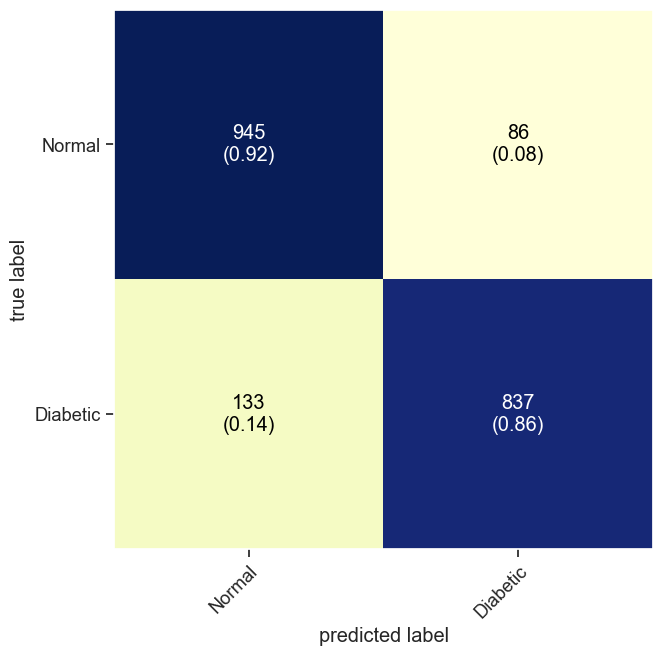

In [39]:
cm = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(conf_mat = cm,figsize=(8,7),class_names = ["Normal","Diabetic"],
                      show_normed = True, cmap ='YlGnBu');

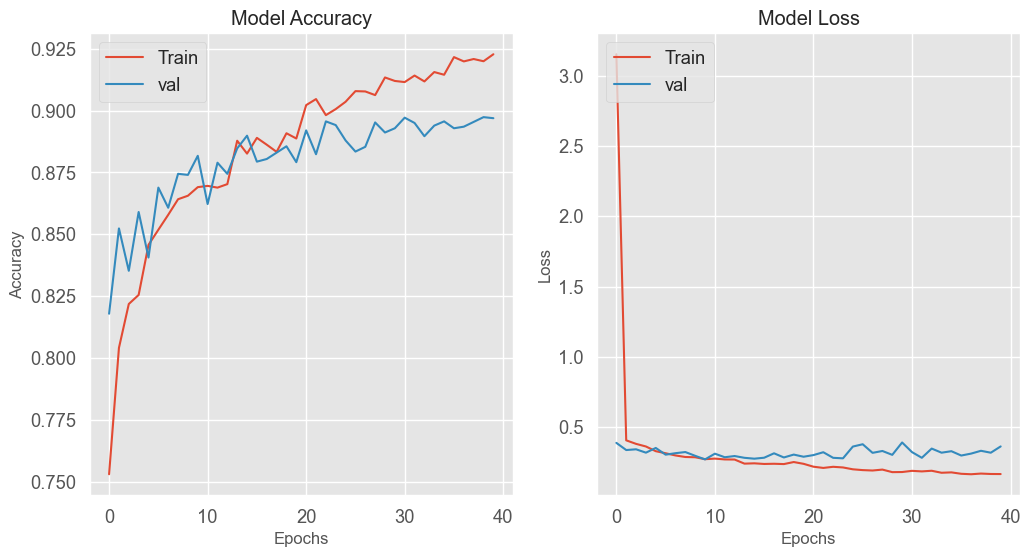

In [40]:
plt.style.use("ggplot")
fig = plt.figure(figsize=(12,6))
epochs = range(1,16)
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train","val"],loc = "upper left")

plt.subplot(1,2,2)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train","val"],loc = "upper left")
plt.show()

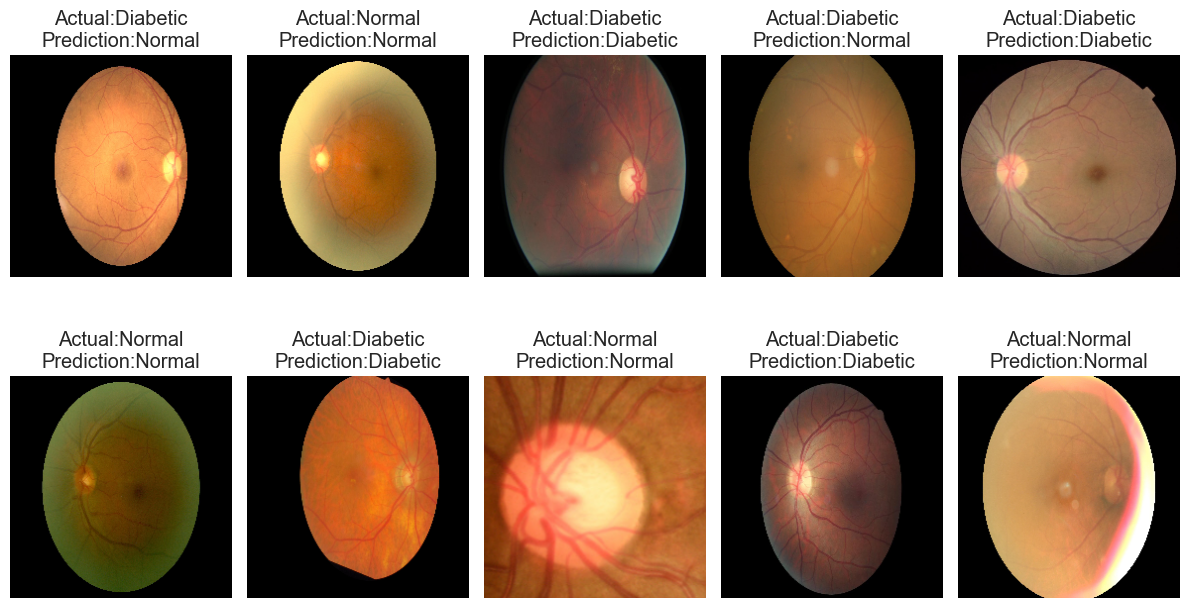

In [41]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(x_test)))
    image = x_test[sample]
    category = y_test[sample]
    pred_category = y_pred[sample]
    
    if category== 0:
        label = "Normal"
    else:
        label = "Diabetic"
        
    if pred_category== 0:
        pred_label = "Normal"
    else:
        pred_label = "Diabetic"
        
    plt.subplot(2,5,i+1)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis('off')
    plt.title("Actual:{}\nPrediction:{}".format(label,pred_label))
plt.tight_layout() 

In [42]:
# Directory containing the testing images
testing_dir = 'Testing Images'

In [47]:
# Function to load and preprocess images
def load_testing_images(directory, image_size):
    images = []
    filenames = []
    for img_filename in os.listdir(directory):
        img_path = os.path.join(directory, img_filename)
        try:
            # Read and resize image
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            img = cv2.resize(img, (image_size, image_size))

            # Convert to array and normalize
            #img_array = np.array(img) / 255.0
            images.append(img)
            filenames.append(img_filename)
        except Exception as e:
            print(f"Error loading image {img_filename}: {e}")
    return np.array(images), filenames

In [48]:
# Load testing images
test_images, test_filenames = load_testing_images(testing_dir, image_size)

In [49]:
# Check if images are loaded correctly
print(f'Loaded {len(test_images)} images for testing')

Loaded 1000 images for testing


In [50]:
# Predict using the model
predictions = model.predict(test_images,batch_size=16)
predicted_categories = (predictions > 0.5).astype(int)

63/63 [==============================] - 5s 86ms/step


In [51]:
predictions

array([[5.82388997e-01],
       [4.38916624e-01],
       [9.18939292e-01],
       [9.67891157e-01],
       [9.86365795e-01],
       [2.68283546e-01],
       [1.00000000e+00],
       [9.99939442e-01],
       [3.47547233e-01],
       [9.51205254e-01],
       [7.83792287e-02],
       [9.36694920e-01],
       [3.91947865e-01],
       [9.99809921e-01],
       [3.57026517e-01],
       [3.57026517e-01],
       [2.97526028e-02],
       [3.64132762e-01],
       [7.55887628e-01],
       [4.17431563e-01],
       [1.52848393e-01],
       [9.88288105e-01],
       [1.88466266e-01],
       [9.08531249e-01],
       [5.43410897e-01],
       [9.69180584e-01],
       [9.77713287e-01],
       [3.40798438e-01],
       [1.09614760e-01],
       [1.19123712e-01],
       [7.46092934e-04],
       [4.45897058e-02],
       [1.00000000e+00],
       [2.00421050e-01],
       [7.14019916e-05],
       [9.99991059e-01],
       [7.06595406e-02],
       [1.26171753e-01],
       [2.81001697e-03],
       [5.09060776e-08],


In [ ]:
# Visualize some test images with their predicted labels

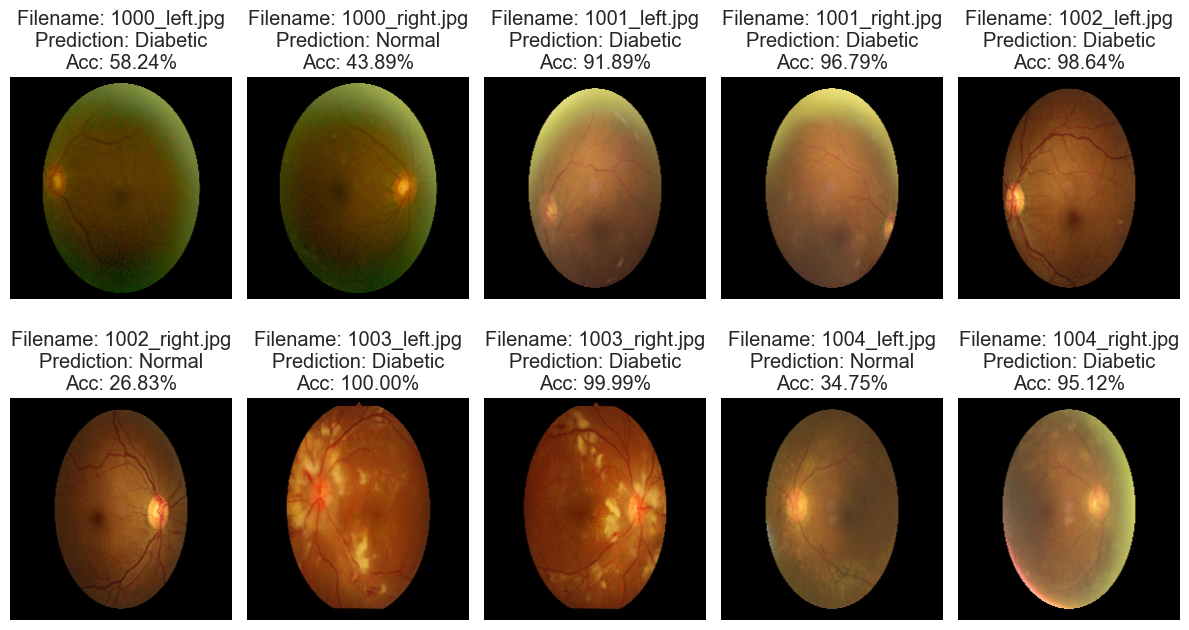

In [52]:
plt.figure(figsize=(12, 7))
for i in range(min(10, len(test_images))):
    plt.subplot(2, 5, i+1)
    
    if test_images[i].dtype != np.uint8:
        image = (test_images[i] * 255).astype(np.uint8)
    else:
        image = test_images[i]
        
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis('off')  # Hide the axes
    pred_label = "Diabetic" if predicted_categories[i] == 1 else "Normal"
    plt.title(f"Filename: {test_filenames[i]}\nPrediction: {pred_label}\nAcc: {predictions[i][0]*100:.2f}%")
plt.tight_layout()
plt.show()

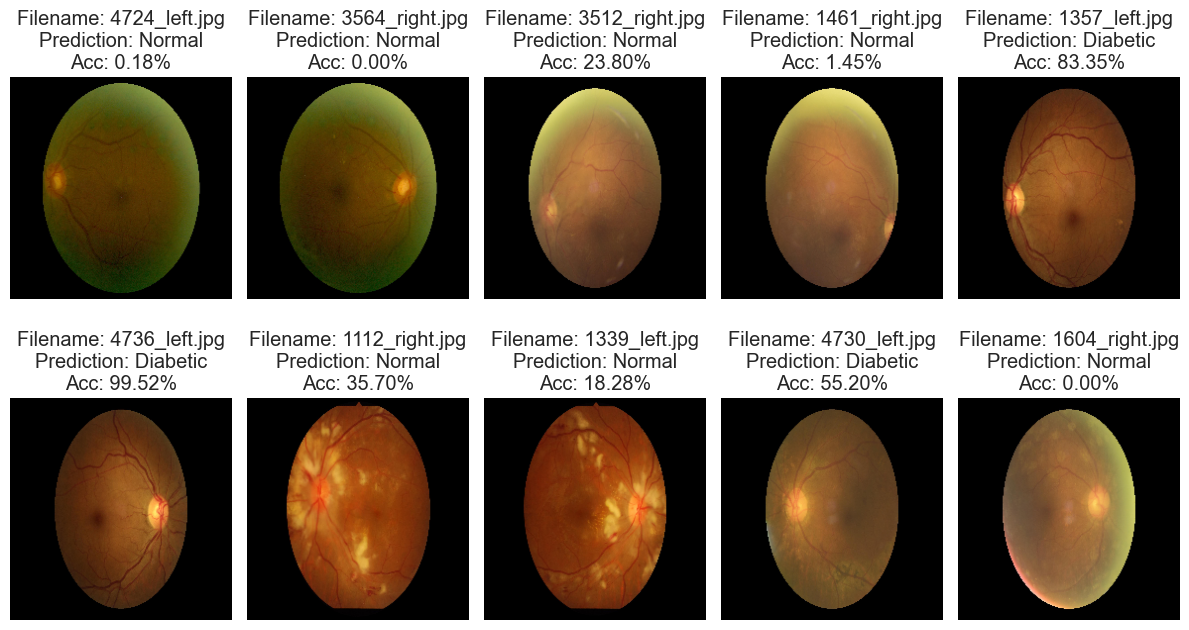

In [54]:
import numpy as np
import matplotlib.pyplot as plt

# Set the number of images you want to display
num_images_to_display = min(10, len(test_images))

# Generate random indices
random_indices = np.random.choice(len(test_images), num_images_to_display, replace=False)

# Plotting the images
plt.figure(figsize=(12, 7))
for i, idx in enumerate(random_indices):
    plt.subplot(2, 5, i+1)

    if test_images[i].dtype != np.uint8:
        image = (test_images[i] * 255).astype(np.uint8)
    else:
        image = test_images[i]
        
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    plt.imshow(image)
    plt.axis('off')  # Hide the axes
    pred_label = "Diabetic" if predicted_categories[idx] == 1 else "Normal"
    plt.title(f"Filename: {test_filenames[idx]}\nPrediction: {pred_label}\nAcc: {predictions[idx][0]*100:.2f}%")
plt.tight_layout()
plt.show()


In [55]:
model.save("vgg19_all_datasets_full_df_diabetic_aug.tf")

INFO:tensorflow:Assets written to: vgg19_all_datasets_full_df_diabetic_aug.tf\assets


INFO:tensorflow:Assets written to: vgg19_all_datasets_full_df_diabetic_aug.tf\assets


**END**